<a href="https://colab.research.google.com/github/santiasann/Theft-Methodology-Research/blob/main/VGG19%20Algorithm%20%26%20Model/VGG-19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import requests
from io import BytesIO
import os
from PIL import Image

In [ ]:

# Load the VGG19 model with the top layer removed
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="otmZRhz8jmqVjiY2GS8S")
project = rf.workspace("workspace-bdrph").project("theft-detection-gge4g")
version = project.version(6)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
%cat {dataset.location}/data.yaml

names:
- card
- crowbar
- hand
- human
- knife
- money
- object
- object-affected
- object-non affected
- pistol
- smartphone
- wallet
nc: 12
roboflow:
  license: CC BY 4.0
  project: theft-detection-gge4g
  url: https://universe.roboflow.com/workspace-bdrph/theft-detection-gge4g/dataset/6
  version: 6
  workspace: workspace-bdrph
test: ../test/images
train: Theft-Detection-6/train/images
val: Theft-Detection-6/valid/images


In [ ]:
data_dir = dataset.location

In [ ]:
# Load the images from the dataset
train_dir ='/content/Theft-Detection-6/train/images'
test_dir = '/content/Theft-Detection-6/test/images'
val_dir = '/content/Theft-Detection-6/valid/images'

In [ ]:
print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

['KravMagaTraining21027_jpg.rf.0cb112962ae553bde7ad977530a5ab16.jpg', 'KravMagaTraining690_jpg.rf.f55a03c3f62c9f0bf3c723d3724f8013.jpg', 'HBbframe00253_jpg.rf.efba694fd6d9061ddedd5c5a69f1407a.jpg', 'RusoClases404_jpg.rf.2fa6accfab7b1267173abab68f9f50c8.jpg', 'KravMagaTraining20863_jpg.rf.6d620eb2adab80ef3059411b93c88fbf.jpg', 'knife_818_jpg.rf.ea94bcffb3b3ce1c02d55abaa75cc14a.jpg', 'MBbframe00265_jpg.rf.2b3ab2f0701a27b91072d4aab8b742ab.jpg', '144_mp4-10_jpg.rf.42a4ef2aae89ba5f3a0f91d5f06cdb75.jpg', 'KravMagaKnifeDefenseTechniques780_jpg.rf.b163d30c4fdabb7e244a303038acfe8d.jpg', 'billete_0003_jpg.rf.52e0ba7316bfb9960fa386b6374f3a7f.jpg', 'knife_722_jpg.rf.7c2d321b95b8084df63ed89e872059ab.jpg', '81_jpeg_jpg.rf.420cf841e33ab8e3c176030522409117.jpg', 'yt-wWEHimK-bNw-0707_jpg.rf.467fc77582caaaf0bc7da0dbce6ffd9a.jpg', 'MBbframe00298_jpg.rf.033011b69387b68e5c92900173b04b14.jpg', 'Robbery050_x264_1570_png.rf.75ee669e61fd0059073e51a65bc6a7b2.jpg', 'billete_0003_jpg.rf.d9e6e0f440f011badf73486246

In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = data_dir,
    label_mode='int',
    batch_size=16,
    seed =0,
    validation_split = 0.2,
    subset ='both'
)

Found 2661 files belonging to 3 classes.
Using 2129 files for training.
Using 532 files for validation.


In [ ]:
label_names= np.array(train_ds.class_names)
print(label_names)

['test' 'train' 'valid']


In [ ]:
def custom_preprocessing(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [ ]:
train_ds = train_ds.map(custom_preprocessing)
val_ds = val_ds.map(custom_preprocessing)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index =0)
val_ds = val_ds.shard(num_shards=2, index = 1)

In [ ]:
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
# Unfreeze the top few layers of the base model
for layer in base_model.layers[-3:]:  # Replace n with the number of layers to unfreeze
    layer.trainable = True

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(len(label_names), activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks= tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
                    )

Epoch 1/50
134/134 [==============================] - 16s 104ms/step - loss: 1.2750 - accuracy: 0.8084 - val_loss: 0.8871 - val_accuracy: 0.8423
Epoch 2/50
134/134 [==============================] - 15s 109ms/step - loss: 0.9028 - accuracy: 0.8187 - val_loss: 0.7682 - val_accuracy: 0.8423
Epoch 3/50
134/134 [==============================] - 14s 107ms/step - loss: 0.8029 - accuracy: 0.8187 - val_loss: 0.6923 - val_accuracy: 0.8423
Epoch 4/50
134/134 [==============================] - 15s 107ms/step - loss: 0.7488 - accuracy: 0.8187 - val_loss: 0.6447 - val_accuracy: 0.8423
Epoch 5/50
134/134 [==============================] - 14s 105ms/step - loss: 0.7046 - accuracy: 0.8187 - val_loss: 0.6107 - val_accuracy: 0.8423
Epoch 6/50
134/134 [==============================] - 14s 104ms/step - loss: 0.6756 - accuracy: 0.8187 - val_loss: 0.5879 - val_accuracy: 0.8423
Epoch 7/50
134/134 [==============================] - 14s 103ms/step - loss: 0.6550 - accuracy: 0.8187 - val_loss: 0.5729 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.2f}')

17/17 [==============================] - 2s 83ms/step - loss: 0.5313 - accuracy: 0.8456
Test accuracy: 0.85


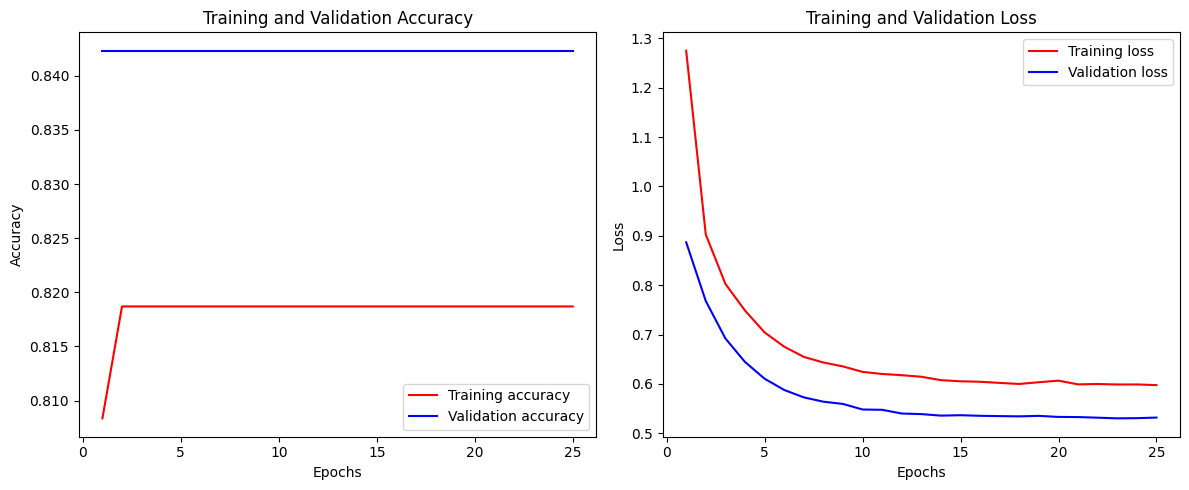

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable holding the training history
history_dict = history.history

# Extract accuracy and loss values for training and validation
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create an array for the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()